# Discrete angular power spectra

This notebook demonstrates how to compute discrete angular power spectra from a catalogue without intermediary maps. The set-up is the same as in the example notebook.

## Setup

General purpose imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

And the *Heracles* imports — here, we import `heracles.ducc`, which is the module that contains a mapper for discrete data, using the [DUCC](https://gitlab.mpcdf.mpg.de/mtr/ducc) package.

In [2]:
import heracles
import heracles.ducc  # requires ducc0
from heracles.notebook import Progress  # requires ipywidgets

## Data set

This notebook uses the [*example data set*](https://dx.doi.org/10.5281/zenodo.13622598). If you do not have the example data already, run the following cell. (If you do have the example data, this will do nothing).

In [3]:
import helpers

with Progress("example data") as progress:
    helpers.get_example_data(progress)

VBox()

## Basic parameters

When working with discrete angular power spectra, the only parameter to be set is `lmax`.

In [4]:
lmax = 1500

## Visibility

The discrete angular power spectra still require information about the a priori distribution of points, which comes from a visibility map. However, since these spectra are not map-based, the information needs to be encoded in harmonic space.

Here, we load a visibility map from a FITS file, and transform it to harmonic space in one go.

In [5]:
# use reading routine to transform to harmonic space
valm = heracles.read_vmap("vmap.fits.gz", transform=True, lmax=lmax)

The result is not a HEALPix map but instead an array of complex-valued spherical harmonic coefficients, as we would expected.

In [6]:
valm.dtype, valm.shape

(dtype('complex128'), (1127251,))

## Catalogues

We now load the example catalogue and set its (non-tomographic) visibility to the spherical harmonic coefficients we just loaded. This works in exactly the same way as for a visibility HEALPix map.

In [7]:
# load the FITS catalogue, does not read any rows
catalog = heracles.FitsCatalog("catalog.fits")

# set the harmonic-space visibility
catalog.visibility = valm

The catalogue interface detects that the visibility is provided in harmonic space, and still function correctly. For example, we can obtain the sky fraction of the catalogue.

In [8]:
# computed from harmonic-space visibility
catalog.fsky

0.051824961017734

Having set up the base catalogue, construct the tomographic bins.

In [9]:
# tomographic binning
catalogs = {i: catalog[f"BIN == {i}"] for i in range(1, 7)}

## Two-point statistics

Computing the discrete angular power spectra of our catalogue is now very straightforward: first, we construct the appropriate `DiscreteMapper`, which uses the DUCC library internally for efficiently computing the required spherical harmonics. Since there are no pixels involved anywhere, we only need to pass it our desired `lmax`.

In [10]:
mapper = heracles.ducc.DiscreteMapper(lmax)

We then construct the fields as in the example notebook, using out discrete mapper.

In [11]:
fields = {
    "POS": heracles.Positions(
        mapper,
        "RA",
        "DEC",
        mask="VIS",
    ),
    "SHE": heracles.Shears(
        mapper,
        "RA",
        "DEC",
        "E1",
        "E2",
        "W",
        mask="WHT",
    ),
}

Mapping the catalogues to these fields is exactly the same as in the example.

In [12]:
with Progress("mapping") as progress:
    data = heracles.map_catalogs(fields, catalogs, parallel=True, progress=progress)

VBox()

However, the result of the mapping is not the same: instead of producing HEALPix maps, the results of the discrete mapper are complex-valued arrays spherical harmonic coefficients.

In [13]:
data["POS", 1].dtype

dtype('complex128')

In fact, we can pass the results of the mapping directly to the routine for computing angular power spectra — no transformation necessary.

In [14]:
cls = heracles.angular_power_spectra(data)

We can then plot the spectra as before, showing a very similar result, but now using 100% organic map-free discrete angular power spectra. Well done!

In [15]:
ell = np.arange(lmax + 1)

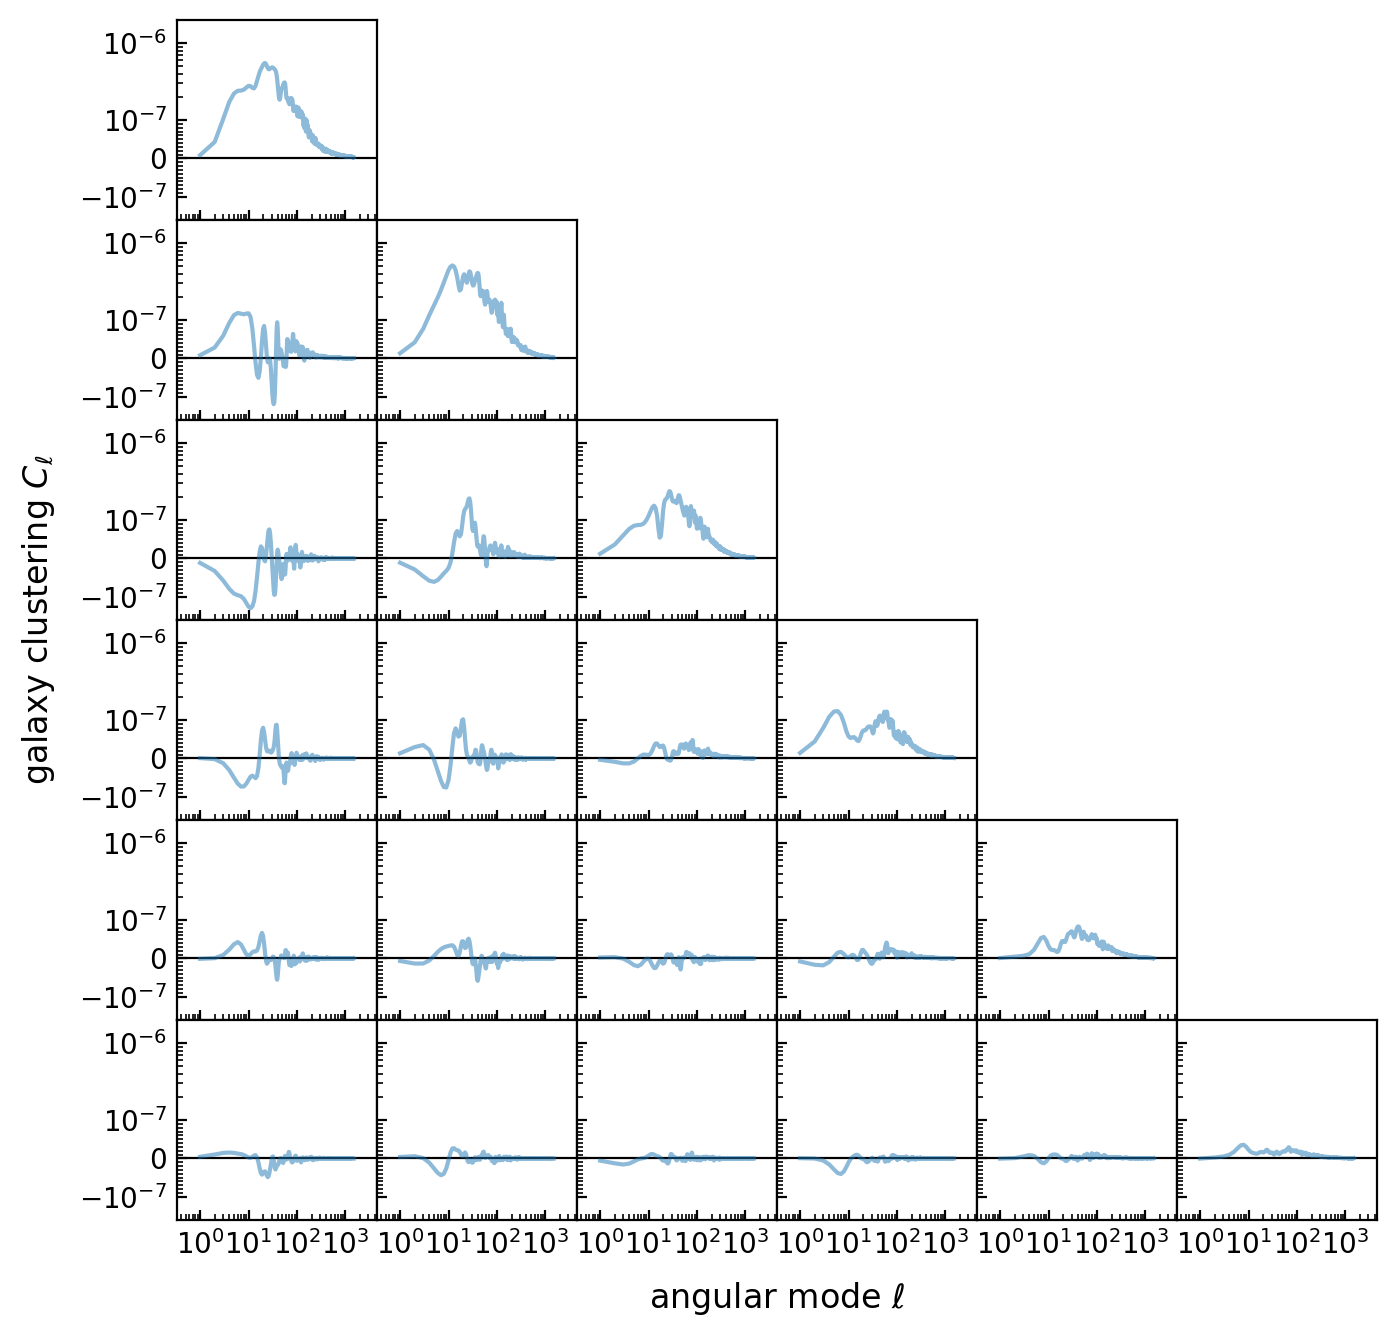

In [16]:
fig, ax = plt.subplots(6, 6, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, 7):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, 7):
        ax[j - 1, i - 1].plot(ell[1:], cls["POS", "POS", i, j][1:], c="C0", lw=1.5, zorder=3.0, alpha=0.5)
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1 / 3, lmax * 3)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(numticks=99, subs=np.arange(0.1, 1.0, 0.1))
ax[0, 0].set_yscale("symlog", linthresh=1e-7, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1))
ax[0, 0].set_ylim(-2e-7, 2e-6)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy clustering $C_\\ell$", x=-0.1, ha="right")

plt.show()

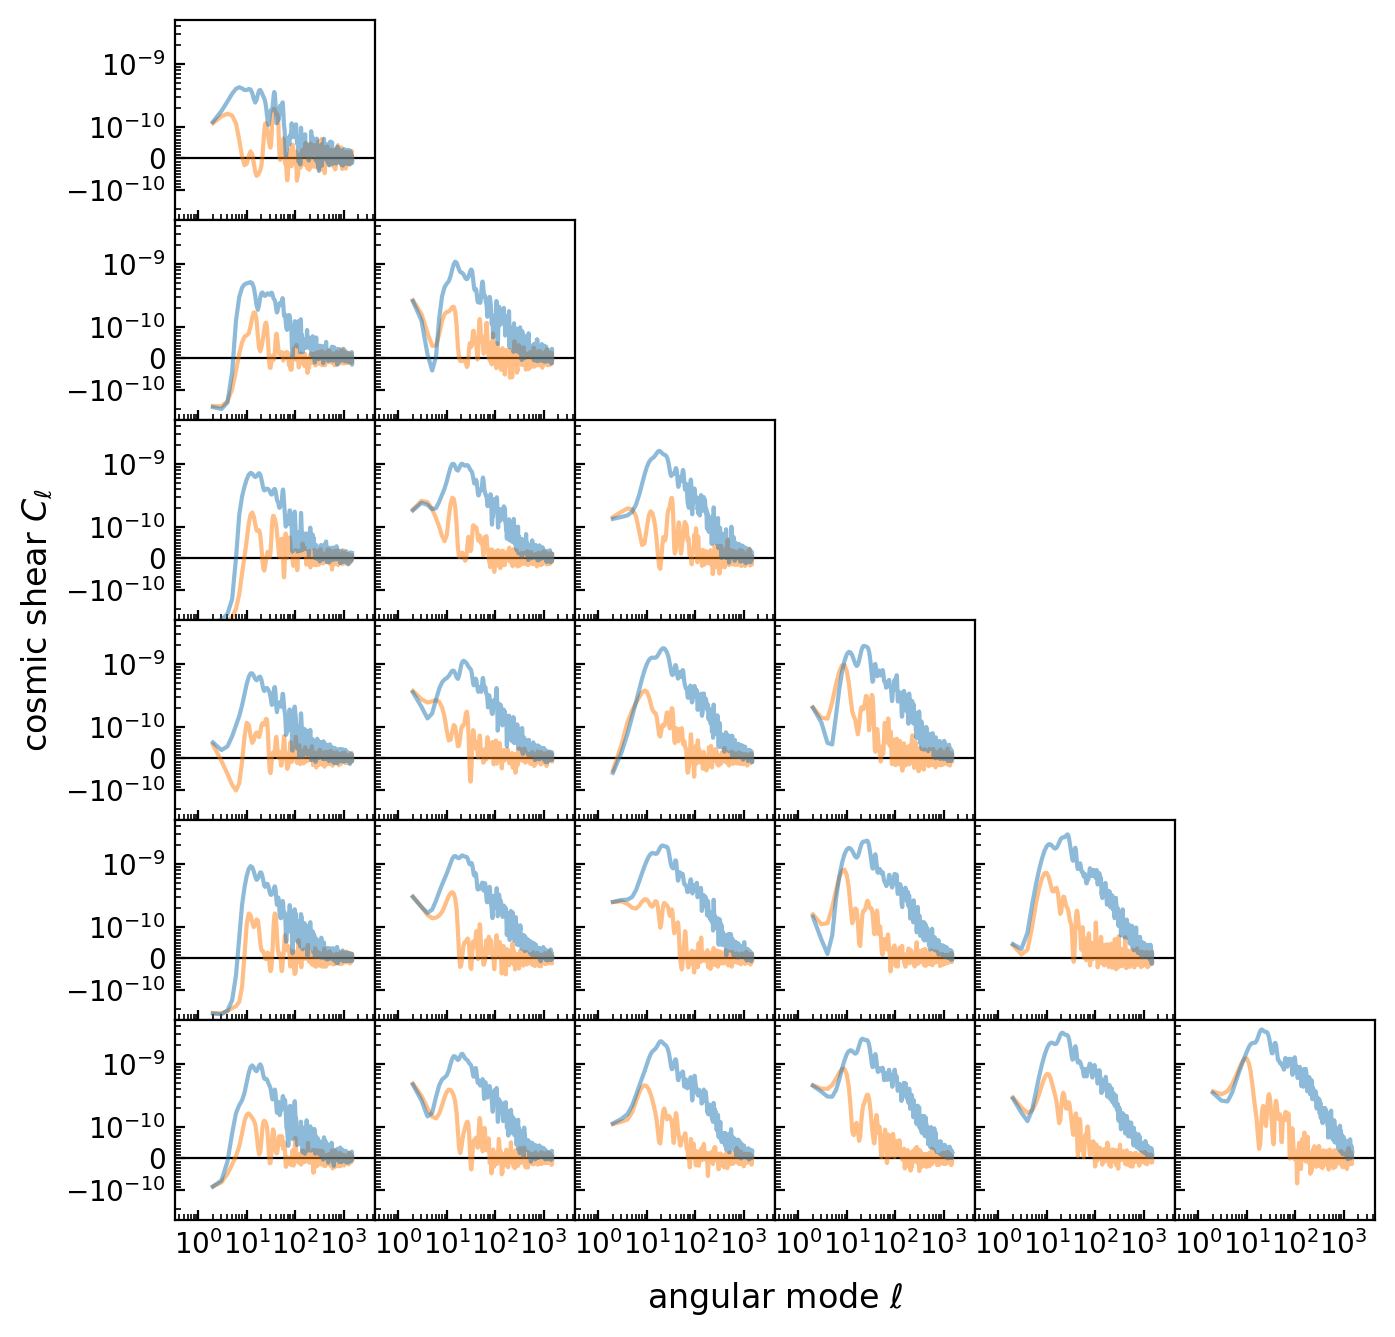

In [17]:
fig, ax = plt.subplots(6, 6, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, 7):
    for j in range(1, i):
        ax[j - 1, i - 1].axis("off")
    for j in range(i, 7):
        ax[j - 1, i - 1].plot(ell[2:], cls["SHE", "SHE", i, j][0, 2:], c="C0", lw=1.5, zorder=3.0, alpha=0.5)
        ax[j - 1, i - 1].plot(ell[2:], cls["SHE", "SHE", i, j][1, 2:], c="C1", lw=1.5, zorder=1.0, alpha=0.5)
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1 / 3, lmax * 3)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(numticks=99, subs=np.arange(0.1, 1.0, 0.1))
ax[0, 0].set_yscale("symlog", linthresh=1e-10, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1))
ax[0, 0].set_ylim(-3e-10, 5e-9)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("cosmic shear $C_\\ell$", x=-0.1, ha="right")

plt.show()

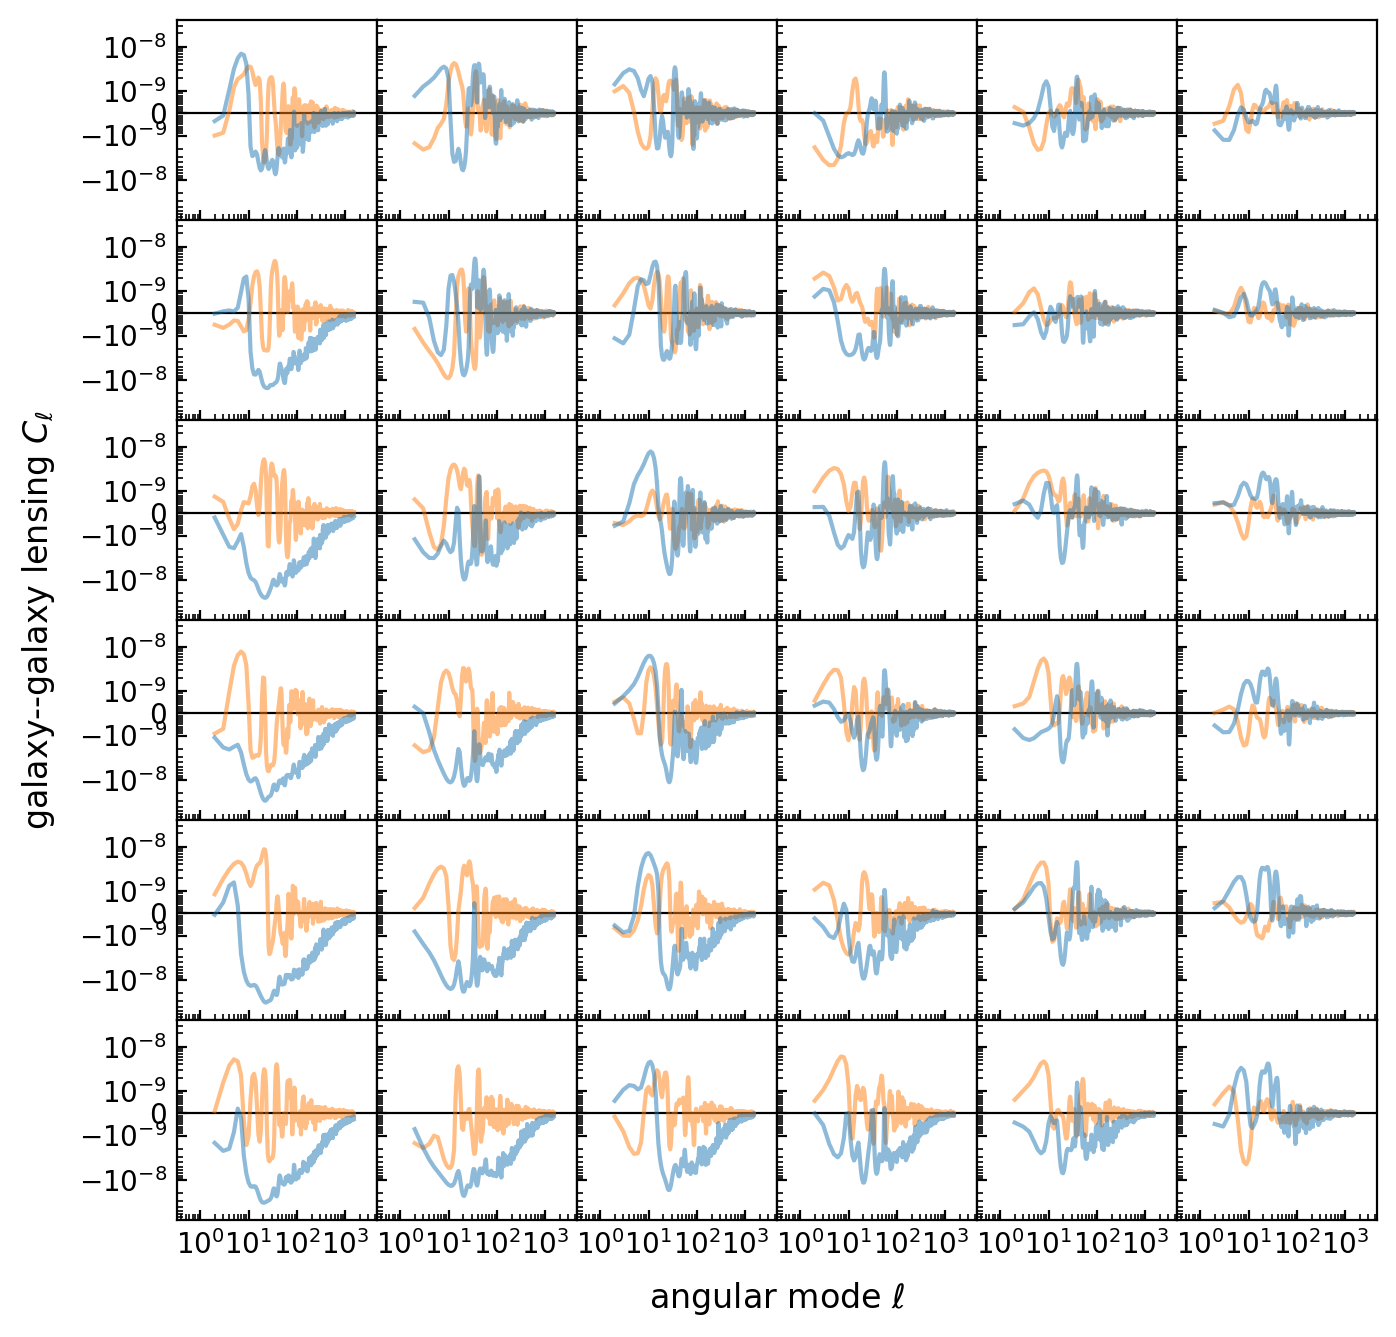

In [18]:
fig, ax = plt.subplots(6, 6, figsize=(6, 6), sharex=True, sharey=True)

for i in range(1, 7):
    for j in range(1, 7):
        ax[j - 1, i - 1].plot(ell[2:], cls["POS", "SHE", i, j][0, 2:], c="C0", lw=1.5, zorder=3.0, alpha=0.5)
        ax[j - 1, i - 1].plot(ell[2:], cls["POS", "SHE", i, j][1, 2:], c="C1", lw=1.5, zorder=1.0, alpha=0.5)
        ax[j - 1, i - 1].axhline(0.0, c="k", lw=0.8, zorder=-1)
        ax[j - 1, i - 1].tick_params(axis="both", which="both", direction="in")

ax[0, 0].set_xscale("log")
ax[0, 0].set_xlim(1 / 3, lmax * 3)
ax[0, 0].xaxis.get_major_locator().set_params(numticks=99)
ax[0, 0].xaxis.get_minor_locator().set_params(numticks=99, subs=np.arange(0.1, 1.0, 0.1))
ax[0, 0].set_yscale("symlog", linthresh=1e-9, linscale=0.45, subs=np.arange(0.1, 1.0, 0.1))
ax[0, 0].set_ylim(-8e-8, 4e-8)

fig.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=1.0, wspace=0.0, hspace=0.0)

fig.supxlabel("angular mode $\\ell$", y=-0.05, va="top")
fig.supylabel("galaxy--galaxy lensing $C_\\ell$", x=-0.1, ha="right")

plt.show()